In [44]:
import torch.nn as nn
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from data.utils import distinct_colors
from models.nn_models import SorghumPartNetInstance

from sklearn.cluster import DBSCAN

In [13]:
def load_model(model, path):
    model = eval(model).load_from_checkpoint(path)
    model.eval()
    return model

def load_data_h5(path, point_key, label_key, lim=100):
    with h5py.File(path) as f:
        data = np.array(f[point_key][:lim])
        label = np.array(f[label_key][:lim])
    return data, label

def get_final_clusters(preds, DBSCAN_eps=1, DBSCAN_min_samples=10):
    try:
        preds = preds.cpu().detach().numpy().squeeze()
        clustering = DBSCAN(eps=DBSCAN_eps, min_samples=DBSCAN_min_samples).fit(preds)
        final_clusters = clustering.labels_
        return final_clusters
    except Exception as e:
        print(e)
        return None

In [21]:
model = load_model("SorghumPartNetInstance", "/space/ariyanzarei/sorghum_segmentation/results/training_logs/SorghumPartNetInstance/SPNS/EXP_02/checkpoints/epoch=8-step=43199.ckpt").cuda()

In [24]:
data, label = load_data_h5("/space/ariyanzarei/sorghum_segmentation/dataset/SPNS/SorghumPartNetFormat/instance_segmentation_validation.hdf5", "points", "labels")
data_t = torch.from_numpy(data).type(torch.DoubleTensor).cuda()
label_t = torch.Tensor(label).float().squeeze().cuda()

In [56]:
i = 20
preds = model(data_t[i : i + 1])
pred_clusters = get_final_clusters(
    preds, 1.12, 4
)
pred_clusters = torch.from_numpy(pred_clusters)
gt_labels = label_t[i].squeeze().int()

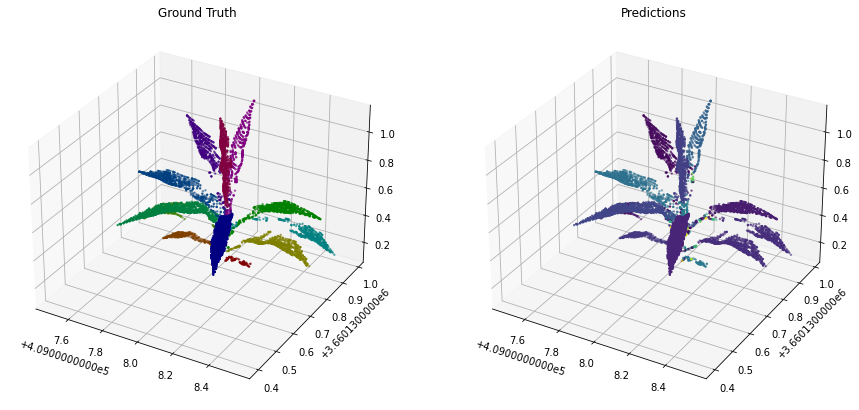

In [57]:
plot_points = data[i]
plot_gt_labels = gt_labels.cpu().numpy()
plot_pred_labels = pred_clusters.cpu().numpy()

d_colors = distinct_colors(len(set(plot_gt_labels.tolist())))
gt_colors = np.zeros((plot_gt_labels.shape[0], 3))
for i, l in enumerate(list(set(plot_gt_labels.tolist()))):
    gt_colors[plot_gt_labels == l, :] = d_colors[i]

d_colors = distinct_colors(len(set(plot_pred_labels.tolist())))
pred_colors = np.zeros((plot_pred_labels.shape[0], 3))
for i, l in enumerate(list(set(plot_pred_labels.tolist()))):
    pred_colors[plot_pred_labels == l, :] = d_colors[i]

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(plot_points[:,0],plot_points[:,1],plot_points[:,2], s=2, c=gt_colors)
ax1.set_title("Ground Truth")

ax2.scatter(plot_points[:,0],plot_points[:,1],plot_points[:,2], s=2, c=pred_clusters)
ax2.set_title("Predictions")

plt.show()

In [83]:
class AveragePrecisionRecall(nn.Module):
    def __init__(self, iou_th, device_name="cpu"):
        super().__init__()
        self.device_name = device_name
        self.thresholds = iou_th

    def get_ious_and_counts(self, pred_clusters, gt_clusters):
        gt_all_cluster_labels = list(set(gt_clusters.int().cpu().numpy().tolist()))
        pr_all_cluster_labels = list(set(pred_clusters.int().cpu().numpy().tolist()))

        ious = []
        for gt_cluster in gt_all_cluster_labels:
            for pr_cluster in pr_all_cluster_labels:
                pr_point_indices = (
                    (pred_clusters == pr_cluster).nonzero().squeeze().cpu().numpy()
                )
                gt_point_indices = (
                    (gt_clusters == gt_cluster).nonzero().squeeze().cpu().numpy()
                )
                intersection = np.intersect1d(
                    pr_point_indices, gt_point_indices, True
                )
                union = np.union1d(pr_point_indices, gt_point_indices)
                iou = len(intersection) / len(union)
                ious.append(iou)
        return np.array(ious), len(gt_all_cluster_labels), len(pr_all_cluster_labels)

    def forward(self, input, target):

        if len(input.shape) != 1:
            raise Exception(
                f"Incorrect shape of the input tensor. It should have 1 dimensions (N) but it has shape {input.shape}. "
            )

        if len(target.shape) != 1:
            raise Exception(
                f"Incorrect shape of the target tensor. It should have 1 dimensions (N) but it has shape {target.shape}. "
            )

        ious, count_gt, count_pred = self.get_ious_and_counts(input, target)
        precisions = []
        recalls = []

        for t in self.thresholds:
            TP = len(ious[ious>t])
            precision = TP/count_pred
            recall = TP/count_gt
            precisions.append(precision)
            recalls.append(recall)

        return np.mean(precisions), np.mean(recalls)

In [86]:
ap_calculator = AveragePrecision([0.25, 0.5, 0.75], "cuda")
AP, AR = ap_calculator(pred_clusters, gt_labels)
print(AP, AR)

0.28205128205128205 0.9166666666666666
